<a href="https://colab.research.google.com/github/alex-bolshunov/linear_regression_ml/blob/main/linear_regression_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup and Initialization

This section contains the code to import all required modules and dataset and define required functions and global variables.

In [786]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [787]:
#define variables
FIG_SIZE = (8,6)
SEED = 5
TEST_SIZE = 0.2
N_ROWS = 3
N_ROUND = 4
scores = []

In [788]:
#import dataset
!curl "https://raw.githubusercontent.com/alex-bolshunov/linear_regression_ml/refs/heads/main/insurance.csv" -o insurance.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 54289  100 54289    0     0   193k      0 --:--:-- --:--:-- --:--:--  192k


In [789]:
#get df
original_df = pd.read_csv("/content/insurance.csv")

In [790]:
#plot linear regression
def plot_pred_true(y_true, y_pred):
  min_val = y_true.min()
  max_val = y_true.max()

  plt.figure(figsize = FIG_SIZE)
  plt.scatter(y_true, y_pred, color = "darkblue", alpha = 0.5, zorder = 5)
  plt.plot([min_val, max_val], [min_val, max_val], color="red", linewidth = 2.5, alpha = 0.7, zorder = 3)
  plt.xlabel("True Values")
  plt.ylabel("Predicted Values")
  plt.title("True vs Predicted Values")
  plt.grid(True, alpha = 0.4)
  plt.show();

#calculate scores
def calculate_scores(y_train, y_pred):
  r2_mse_tuple = r2_score(y_train, y_pred), mean_squared_error(y_train, y_pred)
  scores.append(r2_mse_tuple)
  return r2_mse_tuple

#show scores
def show_scores(r2_mse_tuple):
  print(f"R2 Score: {r2_mse_tuple[0]}")
  print(f"MSE: {r2_mse_tuple[1]}")

#get scores
def get_scores(y_train, y_pred):
  r2_mse_tuple = calculate_scores(y_train, y_pred)
  show_scores(r2_mse_tuple)

### EDA

In this section, we conduct simple exploratory data analysis to determine datatypes, find missing values and outliers, and understand the dataset.

In [791]:
#check dataframe
original_df.head(N_ROWS)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [792]:
#check datatypes
original_df.dtypes

,0
age,int64
sex,object
bmi,float64
children,int64
smoker,object
region,object
charges,float64


In [793]:
#check null values
original_df.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [794]:
#check outliers in charges
pd.concat([original_df['charges'].sort_values().iloc[:5], original_df['charges'].sort_values().iloc[-5:]], ignore_index=True)

,charges
0,1121.87390
1,1131.50660
2,1135.94070
3,1136.39940
4,1137.01100
5,55135.40209
6,58571.07448
7,60021.39897
8,62592.87309
9,63770.42801


In [795]:
#check dataframe for unusual values
original_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


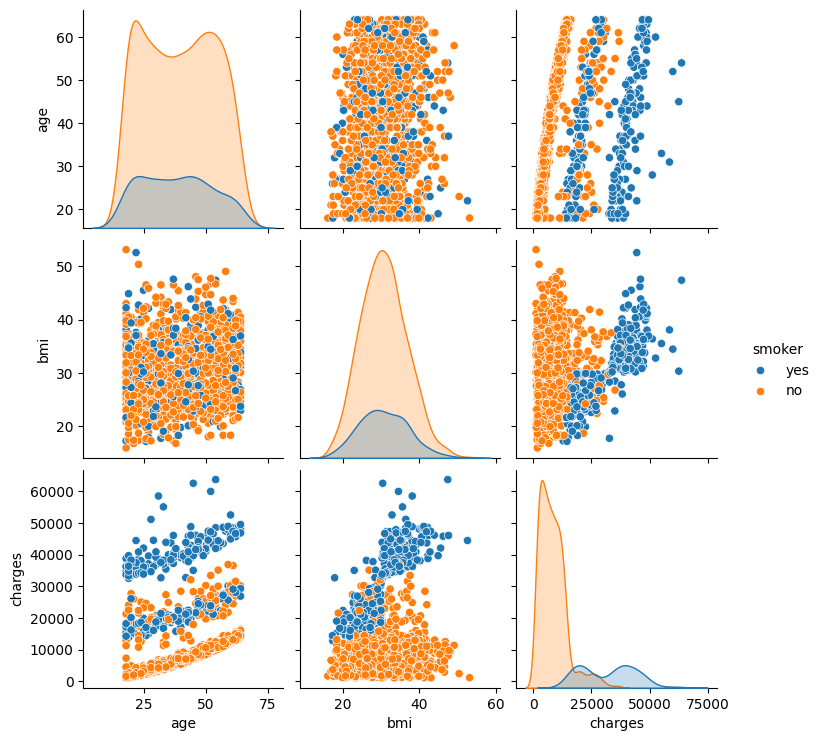

In [796]:
#scatterplot for numerical values
sns.pairplot(original_df[["age", "bmi", "charges", "smoker"]], hue = "smoker")
plt.show();

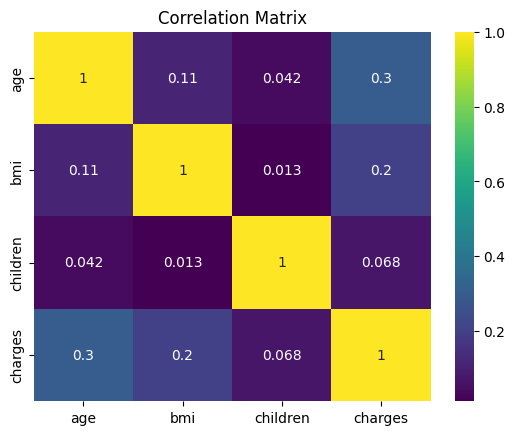

In [797]:
#correlation matrix
sns.heatmap(original_df[["age", "bmi", "children", "charges"]].corr(), annot=True, cmap = "viridis")
plt.title("Correlation Matrix")
plt.show();

The dataset doesn't contain any outliers or missing values. Most features are in suitable datatypes. However, we'll need to transform some features (sec, smoker) and drop others (region). There is no strong correlation between bmi, children, age, and charges features. The maximum value is 0.3 (charges x age).

### Data Preprocessing

In this section, we preprocess the data and get it ready for modeling.

In [798]:
test_df = original_df.drop(["region"], axis = 1)

In [799]:
test_df = pd.get_dummies(data=test_df, dtype = 'int64')

In [800]:
#move charges to the end
test_df = test_df.iloc[:, [0, 1, 2, 4, 5, 6, 7, 3]]

In [801]:
test_df.head(N_ROWS)

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,charges
0,19,27.90,0,1,0,0,1,16884.9240
1,18,33.77,1,0,1,1,0,1725.5523
2,28,33.00,3,0,1,1,0,4449.4620


We created dummy variables for sex and smoker features (0 - false, 1 - true); the order was rearranged for easier further manipulation of a dataset.

### EDA+

After feature engineering, we conduct some additional EDA.

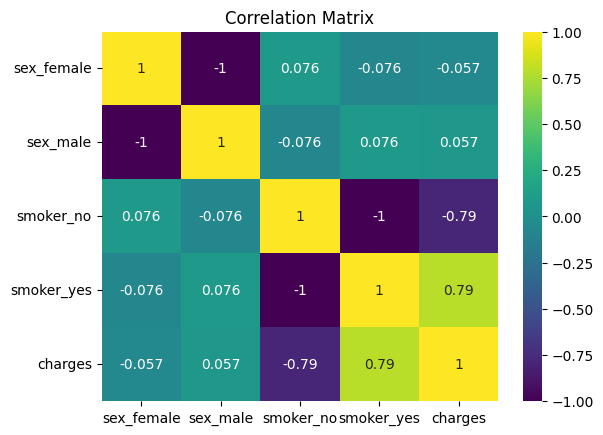

In [802]:
#check correlation between
sns.heatmap(test_df.iloc[:, 3:].corr(), annot=True, cmap = "viridis")
plt.title("Correlation Matrix")
plt.show();

We investigated the correlation between variables further. There is a strong correlation between smoker and charges features.

### Modeling (training, evaluation, results)

In this section we train various models, evaluate their performance and show final results. We'll start with simplier models and make them more complex along the way.  

In [803]:
y = test_df["charges"]

#### 2 Features Model

We'll use 2 features for this model: smoker_no and smoker_yes.

In [804]:
X1 = test_df.drop(["bmi", "children", "age", "sex_female", "sex_male", "charges"], axis=1)

In [805]:
X1.head(N_ROWS)

,smoker_no,smoker_yes
0,0,1
1,1,0
2,1,0


In [806]:
X_tr, X_tt, y_tr, y_tt = train_test_split(X1, y, test_size=TEST_SIZE, random_state=SEED)

In [807]:
model_1 = LinearRegression()

model_1.fit(X_tr, y_tr)

y_hat_1 = model_1.predict(X_tt)

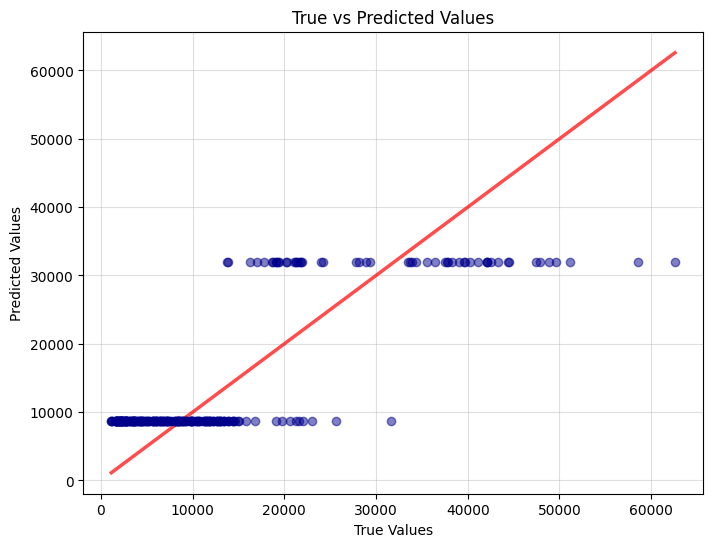

In [808]:
plot_pred_true(y_tt, y_hat_1)

In [809]:
get_scores(y_tt, y_hat_1)

R2 Score: 0.6536370962790048
MSE: 52574009.52939426


#### 4 Features Model

We'll use 4 features for this model: smoker_no, smoker_yes, age, and bmi.

In [810]:
X2 = test_df.drop(["children", "sex_female", "sex_male", "charges"], axis=1)

In [811]:
X2.head(N_ROWS)

,age,bmi,smoker_no,smoker_yes
0,19,27.90,0,1
1,18,33.77,1,0
2,28,33.00,1,0


In [812]:
X_tr, X_tt, y_tr, y_tt = train_test_split(X2, y, test_size=TEST_SIZE, random_state=SEED)

In [813]:
model_2 = LinearRegression()

model_2.fit(X_tr, y_tr)

y_hat_2 = model_2.predict(X_tt)

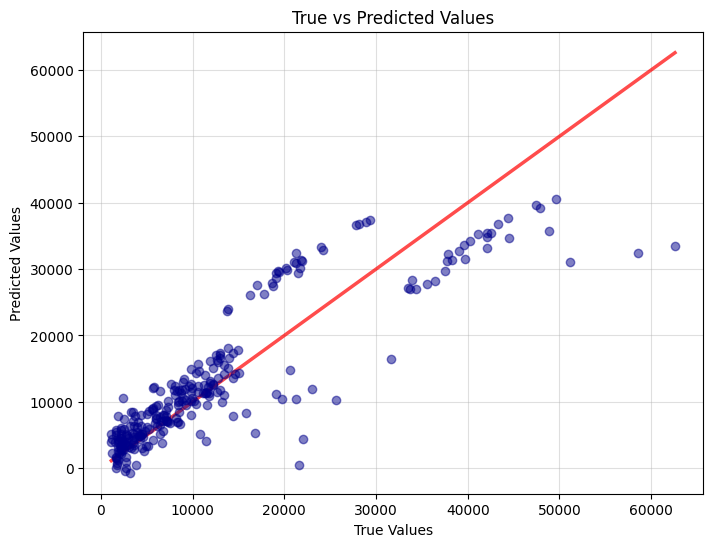

In [814]:
plot_pred_true(y_tt, y_hat_2)

In [815]:
get_scores(y_tt, y_hat_2)

R2 Score: 0.7793451556442221
MSE: 33492934.044727717


#### All Features Model

For the final model, all features will be used.

In [816]:
X3 = test_df.drop(["charges"], axis=1)

In [817]:
X3.head(N_ROWS)

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes
0,19,27.90,0,1,0,0,1
1,18,33.77,1,0,1,1,0
2,28,33.00,3,0,1,1,0


In [818]:
X_tr, X_tt, y_tr, y_tt = train_test_split(X3, y, test_size=TEST_SIZE, random_state=SEED)

In [819]:
model_3 = LinearRegression()

model_3.fit(X_tr, y_tr)

y_hat_3 = model_3.predict(X_tt)

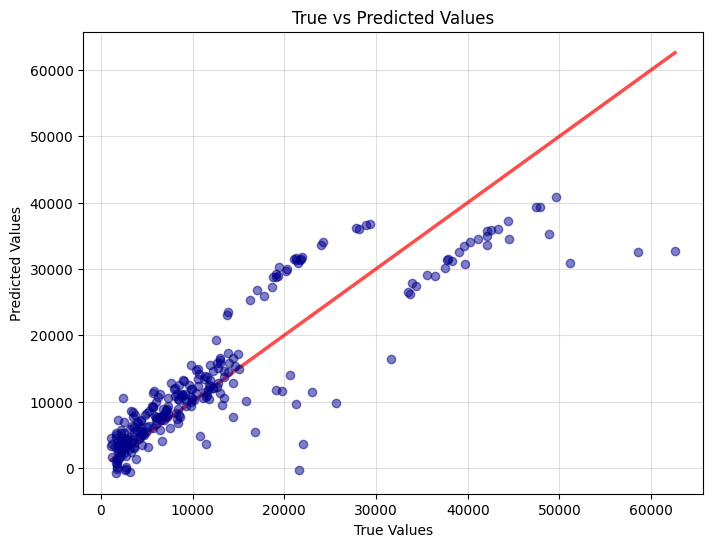

In [820]:
plot_pred_true(y_tt, y_hat_3)

In [821]:
get_scores(y_tt, y_hat_3)

R2 Score: 0.7777630966249414
MSE: 33733072.88483496


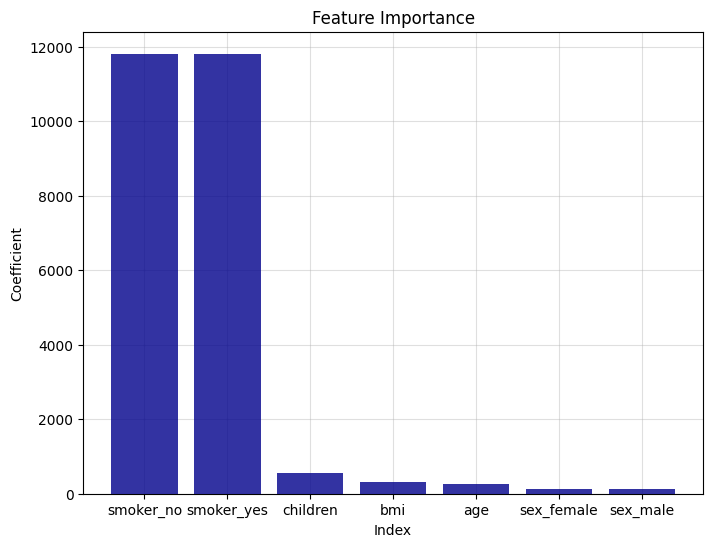

In [822]:
#get value of coefficients from model, sort ind, plot results
imp = np.abs(model_3.coef_)
n_features = len(imp)
x_axis = range(n_features)
ind = np.argsort(imp)[::-1]
feature_names = X3.columns[ind]



plt.figure(figsize= FIG_SIZE)
plt.bar(x_axis, imp[ind], color='darkblue', alpha=0.8, zorder = 3)
plt.xlabel("Index")
plt.ylabel("Coefficient")
plt.title("Feature Importance")
plt.xticks(x_axis, feature_names)
plt.grid(True, alpha = 0.4)
plt.show();

#### Results

In [823]:
model_names = ["2 Features", "4 Features", "All Features"]

In [824]:
#print scores
for i in range(len(model_names)):
  print(f"Model #{i+1}: {model_names[i]}")
  print(f"R2 Score: {round(scores[i][0], N_ROUND)}")
  print(f"MSE: {round(scores[i][1])}\n")

Model #1: 2 Features
R2 Score: 0.6536
MSE: 52574010

Model #2: 4 Features
R2 Score: 0.7793
MSE: 33492934

Model #3: All Features
R2 Score: 0.7778
MSE: 33733073



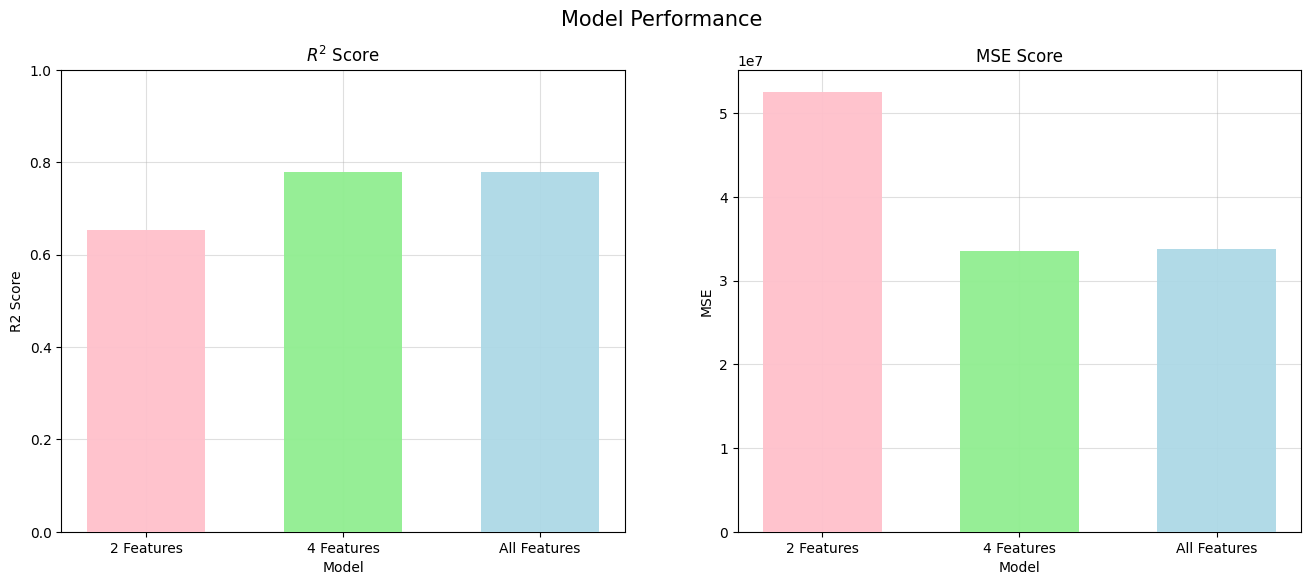

In [825]:
#plot scores
colors = ["pink", "lightgreen", "lightblue"]

fig,ax = plt.subplots(1, 2, figsize = (16, 6))

ax[0].bar(model_names, [score[0] for score in scores], color = colors, alpha = 0.95, zorder = 3, width = 0.6)
ax[0].set_xlabel("Model")
ax[0].set_ylabel("R2 Score")
ax[0].set_title("$R^2$ Score")
ax[0].grid(True, alpha = 0.4)
ax[0].set_ylim((0,1));

ax[1].bar(model_names, [score[1] for score in scores], color = colors, alpha = 0.95, zorder = 3,width = 0.6)
ax[1].set_xlabel("Model")
ax[1].set_ylabel("MSE")
ax[1].set_title("MSE Score")
ax[1].grid(True, alpha = 0.4)
#ax[1].set_ylim((0,1));

plt.suptitle("Model Performance", fontsize = 15)
plt.show();



The simplest model performed the worst. The values of scores are almost the same for the second and third models. However, by testing various random states, in most cases, the second model performs slightly better by $ R^2 $ score and somewhat worse by the MSE score. It is worth noting that adding extra features to the second model doesn't contribute to better performance. According to the 3rd model, the feature with the highest importance is the "smoker."